# Code Coverage

In the [previous chapter](Fuzzer.ipynb), we introduced _basic fuzzing_ – that is, generating random inputs to test programs.  How do we measure the effectiveness of these tests?  One way would be to check the number (and seriousness) of bugs found; but if bugs are scarce, we need a _proxy for the likelihood of a test to uncover a bug._  In this chapter, we introduce the concept of *code coverage*, measuring which parts of a program are actually executed during a test run.  Measuring such coverage is also crucial for test generators that attempt to cover as much code as possible.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('8HxW8j9287A')

**Prerequisites**

* You need some understanding of how a program is executed.
* You should have learned about basic fuzzing in the [previous chapter](Fuzzer.ipynb).

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.Coverage import <identifier>
```

and then make use of the following features.


This chapter introduces a `Coverage` class allowing you to measure coverage for Python programs. Within the context of this book, we use coverage information to guide fuzzing towards uncovered locations.

The typical usage of the `Coverage` class is in conjunction with a `with` clause:

```python
>>> with Coverage() as cov:
>>>     cgi_decode("a+b")
```
Printing out a coverage object shows the covered functions, with covered lines prefixed as `#`:

```python
>>> print(cov)
   1  def cgi_decode(s: str) -> str:
   2      """Decode the CGI-encoded string `s`:
   3         * replace '+' by ' '
   4         * replace "%xx" by the character with hex number xx.
   5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
   6  
   7      # Mapping of hex digits to their integer values
#  8      hex_values = {
#  9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
# 10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
# 11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
# 12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
  13      }
  14  
# 15      t = ""
# 16      i = 0
# 17      while i < len(s):
# 18          c = s[i]
# 19          if c == '+':
# 20              t += ' '
# 21          elif c == '%':
  22              digit_high, digit_low = s[i + 1], s[i + 2]
  23              i += 2
  24              if digit_high in hex_values and digit_low in hex_values:
  25                  v = hex_values[digit_high] * 16 + hex_values[digit_low]
  26                  t += chr(v)
  27              else:
  28                  raise ValueError("Invalid encoding")
  29          else:
# 30              t += c
# 31          i += 1
# 32      return t


```
The `trace()` method returns the _trace_ – that is, the list of locations executed in order. Each location comes as a pair (`function name`, `line`).

```python
>>> cov.trace()
[('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 12),
 ('cgi_decode', 8),
 ('cgi_decode', 12),
 ('cgi_decode', 8),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 32)]
```
The `coverage()` method returns the _coverage_, that is, the set of locations in the trace executed at least once:

```python
>>> cov.coverage()
{('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 32)}
```
Coverage sets can be subject to set operations, such as _intersection_ (which locations are covered in multiple executions) and _difference_ (which locations are covered in run _a_, but not _b_).

The chapter also discusses how to obtain such coverage from C programs.

![](PICS/Coverage-synopsis-1.svg)



In [2]:
import bookutils

In [3]:
# ignore
from typing import Any, Optional, Callable, List, Type, Set, Tuple

## A CGI Decoder

We start by introducing a simple Python function that decodes a CGI-encoded string.  CGI encoding is used in URLs (i.e., Web addresses) to encode characters that would be invalid in a URL, such as blanks and certain punctuation:

* Blanks are replaced by `'+'`
* Other invalid characters are replaced by '`%xx`', where `xx` is the two-digit hexadecimal equivalent.

In CGI encoding, the string `"Hello, world!"` would thus become `"Hello%2c+world%21"` where `2c` and `21` are the hexadecimal equivalents of `','` and `'!'`, respectively.

The function `cgi_decode()` takes such an encoded string and decodes it back to its original form.  Our implementation replicates the code from \cite{Pezze2008}.  (It even includes its bugs – but we won't reveal them at this point.)

In [4]:
def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

Here is an example of how `cgi_decode()` works:

In [5]:
cgi_decode("Hello+world")

'Hello world'

If we want to systematically test `cgi_decode()`, how would we proceed?

The testing literature distinguishes two ways of deriving tests: _Black-box testing_ and _White-box testing._

## Black-Box Testing

The idea of *black-box testing* is to derive tests from the _specification_.  In the above case, we thus would have to test `cgi_decode()` by the features specified and documented, including

* testing for correct replacement of `'+'`;
* testing for correct replacement of `"%xx"`;
* testing for non-replacement of other characters; and
* testing for recognition of illegal inputs.

Here are four assertions (tests) that cover these four features.  We can see that they all pass:

In [6]:
assert cgi_decode('+') == ' '
assert cgi_decode('%20') == ' '
assert cgi_decode('abc') == 'abc'

try:
    cgi_decode('%?a')
    assert False
except ValueError:
    pass

The advantage of black-box testing is that it finds errors in the _specified_ behavior.  It is independent from a given implementation, and thus allows to create test even before implementation.  The downside is that _implemented_ behavior typically covers more ground than _specified_ behavior, and thus tests based on specification alone typically do not cover all implementation details.

## White-Box Testing

In contrast to black-box testing, *white-box testing* derives tests from the _implementation_, notably the internal structure.  White-Box testing is closely tied to the concept of _covering_ structural features of the code.  If a statement in the code is not executed during testing, for instance, this means that an error in this statement cannot be triggered either.  White-Box testing thus introduces a number of *coverage criteria* that have to be fulfilled before the test can be said to be sufficient.  The most frequently used coverage criteria are

* *Statement coverage* – each statement in the code must be executed by at least one test input.
* *Branch coverage* – each branch in the code must be taken by at least one test input.  (This translates to each `if` and `while` decision once being true, and once being false.)

Besides these, there are far more coverage criteria, including sequences of branches taken, loop iterations taken (zero, one, many), data flows between variable definitions and usages, and many more; \cite{Pezze2008} has a great overview.

Let us consider `cgi_decode()`, above, and reason what we have to do such that each statement of the code is executed at least once.  We'd have to cover

* The block following `if c == '+'`
* The two blocks following `if c == '%'` (one for valid input, one for invalid)
* The final `else` case for all other characters.

This results in the same conditions as with black-box testing, above; again, the assertions above indeed would cover every statement in the code.  Such a correspondence is actually pretty common, since programmers tend to implement different behaviors in different code locations; and thus, covering these locations will lead to test cases that cover the different (specified) behaviors.

The advantage of white-box testing is that it finds errors in _implemented_ behavior.  It can be conducted even in cases where the specification does not provide sufficient details; actually, it helps in identifying (and thus specifying) corner cases in the specification.  The downside is that it may miss _non-implemented_ behavior: If some specified functionality is missing, white-box testing will not find it.

## Tracing Executions

One nice feature of white-box testing is that one can actually automatically assess whether some program feature was covered.  To this end, one _instruments_ the execution of the program such that during execution, a special functionality keeps track of which code was executed.  After testing, this information can be passed to the programmer, who can then focus on writing tests that cover the yet uncovered code.

In most programming languages, it is rather difficult to set up programs such that one can trace their execution.  Not so in Python.  The function `sys.settrace(f)` allows to define a *tracing function* `f()` that is called for each and every line executed.  Even better, it gets access to the current function and its name, current variable contents, and more.  It is thus an ideal tool for *dynamic analysis* – that is, the analysis of what actually happens during an execution.

To illustrate how this works, let us again look into a specific execution of `cgi_decode()`.

In [7]:
cgi_decode("a+b")

'a b'

To track how the execution proceeds through `cgi_decode()`, we make use of `sys.settrace()`.  First, we define the _tracing function_ that will be called for each line.  It has three parameters: 

* The `frame` parameter gets you the current _frame_, allowing access to the current location and variables:
    * `frame.f_code` is the currently executed code with `frame.f_code.co_name` being the function name;
    * `frame.f_lineno` holds the current line number; and
    * `frame.f_locals` holds the current local variables and arguments.
* The `event` parameter is a string with values including `"line"` (a new line has been reached) or `"call"` (a function is being called).
* The `arg` parameter is an additional _argument_ for some events; for `"return"` events, for instance, `arg` holds the value being returned.

We use the tracing function for simply reporting the current line executed, which we access through the `frame` argument.

In [8]:
from types import FrameType, TracebackType

In [9]:
coverage = []

In [10]:
def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
    """Trace program execution. To be passed to sys.settrace()."""
    if event == 'line':
        global coverage
        function_name = frame.f_code.co_name
        lineno = frame.f_lineno
        coverage.append(lineno)

    return traceit

We can switch tracing on and off with `sys.settrace()`:

In [11]:
import sys

In [12]:
def cgi_decode_traced(s: str) -> None:
    global coverage
    coverage = []
    sys.settrace(traceit)  # Turn on
    cgi_decode(s)
    sys.settrace(None)    # Turn off

When we compute `cgi_decode("a+b")`, we can now see how the execution progresses through `cgi_decode()`.  After the initialization of `hex_values`, `t`, and `i`, we see that the `while` loop is taken three times – one for every character in the input.

In [13]:
cgi_decode_traced("a+b")
print(coverage)

[8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 10, 8, 10, 8, 10, 8, 10, 8, 10, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 11, 8, 12, 8, 12, 8, 15, 16, 17, 18, 19, 21, 30, 31, 17, 18, 19, 20, 31, 17, 18, 19, 21, 30, 31, 17, 32]


Which lines are these, actually?  To this end, we get the source code of `cgi_decode_code` and encode it into an array `cgi_decode_lines`, which we will then annotate with coverage information.  First, let us get the source code of `cgi_encode`:

In [14]:
import inspect

In [15]:
cgi_decode_code = inspect.getsource(cgi_decode)

`cgi_decode_code` is a string holding the source code.  We can print it out with Python syntax highlighting:

In [16]:
from bookutils import print_content, print_file

In [17]:
print_content(cgi_decode_code[:300] + "...", ".py")

def cgi_decode(s: str) -> str:
    """Decode the CGI-encoded string `s`:
       * replace '+' by ' '
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_v...

Using `splitlines()`, we split the code into an array of lines, indexed by line number.

In [18]:
cgi_decode_lines = [""] + cgi_decode_code.splitlines()

`cgi_decode_lines[L]` is line L of the source code.

In [19]:
cgi_decode_lines[1]

'def cgi_decode(s: str) -> str:'

We see that the first line (9) executed is actually the initialization of `hex_values`...

In [20]:
cgi_decode_lines[9:13]

["        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,",
 "        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,",
 "        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,",
 "        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,"]

... followed by the initialization of `t`:

In [21]:
cgi_decode_lines[15]

'    t = ""'

To see which lines actually have been covered at least once, we can convert `coverage` into a set:

In [22]:
covered_lines = set(coverage)
print(covered_lines)

{32, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 30, 31}


Let us print out the full code, annotating lines not covered with '#':

In [23]:
for lineno in range(1, len(cgi_decode_lines)):
    if lineno not in covered_lines:
        print("# ", end="")
    else:
        print("  ", end="")
    print("%2d  " % lineno, end="")
    print_content(cgi_decode_lines[lineno], '.py')
    print()

#  1  def cgi_decode(s: str) -> str:
#  2      """Decode the CGI-encoded string `s`:
#  3         * replace '+' by ' '
#  4         * replace "%xx" by the character with hex number xx.
#  5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
#  6  
#  7      # Mapping of hex digits to their integer values
   8      hex_values = {
   9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
  10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
  11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
  12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
# 13      }
# 14  
  15      t = ""
  16      i = 0
  17      while i < len(s):
  18          c = s[i]
  19          if c == '+':
  20              t += ' '
  21          elif c == '%':
# 22              digit_high, digit_low = s[i + 1], s[i + 2]
# 23              i += 2
# 24              if digit_high in hex_values and digit_low in hex_values:
# 25                  v = hex_values[digit_high] * 

We see that a number of lines (notably comments) have not been executed, simply because they are not executable.  However, we also see that the lines under `if c == '%'` have _not_ been executed yet.  If `"a+b"` were our only test case so far, this missing coverage would now encourage us to create another test case that actually covers these lines.

## A Coverage Class

In this book, we will make use of coverage again and again – to _measure_ the effectiveness of different test generation techniques, but also to _guide_ test generation towards code coverage.  Our previous implementation with a global `coverage` variable is a bit cumbersome for that.  We therefore implement some functionality that will help us measure coverage easily.

The key idea of getting coverage is to make use of the Python `with` statement.  The general form

```python
with OBJECT [as VARIABLE]:
    BODY
```

executes `BODY` with `OBJECT` being defined (and stored in `VARIABLE`).  The interesting thing is that at the beginning and end of `BODY`, the special methods `OBJECT.__enter__()` and `OBJECT.__exit__()` are automatically invoked; even if `BODY` raises an exception.  This allows us to define a `Coverage` object where `Coverage.__enter__()` automatically turns on tracing and `Coverage.__exit__()` automatically turns off tracing again.  After tracing, we can make use of special methods to access the coverage.  This is what this looks like during usage:

```python
with Coverage() as cov:
    function_to_be_traced()
c = cov.coverage()
```

Here, tracing is automatically turned on during `function_to_be_traced()` and turned off again after the `with` block; afterwards, we can access the set of lines executed.

Here's the full implementation with all its bells and whistles.  You don't have to get everything; it suffices that you know how to use it:

In [24]:
Location = Tuple[str, int]

In [25]:
class Coverage:
    """Track coverage within a `with` block. Use as
    ```
    with Coverage() as cov:
        function_to_be_traced()
    c = cov.coverage()
    ```
    """

    def __init__(self) -> None:
        """Constructor"""
        self._trace: List[Location] = []

    # Trace function
    def traceit(self, frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
        """Tracing function. To be overloaded in subclasses."""
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        if event == "line":
            function_name = frame.f_code.co_name
            lineno = frame.f_lineno
            if function_name != '__exit__':  # avoid tracing ourselves:
                self._trace.append((function_name, lineno))

        return self.traceit

    def __enter__(self) -> Any:
        """Start of `with` block. Turn on tracing."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_type: Type, exc_value: BaseException, 
                 tb: TracebackType) -> Optional[bool]:
        """End of `with` block. Turn off tracing."""
        sys.settrace(self.original_trace_function)
        return None  # default: pass all exceptions

    def trace(self) -> List[Location]:
        """The list of executed lines, as (function_name, line_number) pairs"""
        return self._trace

    def coverage(self) -> Set[Location]:
        """The set of executed lines, as (function_name, line_number) pairs"""
        return set(self.trace())

    def function_names(self) -> Set[str]:
        """The set of function names seen"""
        return set(function_name for (function_name, line_number) in self.coverage())

    def __repr__(self) -> str:
        """Return a string representation of this object.
           Show covered (and uncovered) program code"""
        t = ""
        for function_name in self.function_names():
            # Similar code as in the example above
            try:
                fun = eval(function_name)
            except Exception as exc:
                t += f"Skipping {function_name}: {exc}"
                continue

            source_lines, start_line_number = inspect.getsourcelines(fun)
            for lineno in range(start_line_number, start_line_number + len(source_lines)):
                if (function_name, lineno) in self.trace():
                    t += "# "
                else:
                    t += "  "
                t += "%2d  " % lineno
                t += source_lines[lineno - start_line_number]

        return t

Let us put this to use:

In [26]:
with Coverage() as cov:
    cgi_decode("a+b")

print(cov.coverage())

{('cgi_decode', 11), ('cgi_decode', 8), ('cgi_decode', 30), ('cgi_decode', 20), ('cgi_decode', 17), ('cgi_decode', 10), ('cgi_decode', 16), ('cgi_decode', 32), ('cgi_decode', 19), ('cgi_decode', 9), ('cgi_decode', 12), ('cgi_decode', 18), ('cgi_decode', 31), ('cgi_decode', 15), ('cgi_decode', 21)}


As you can see, the `Coverage()` class not only keeps track of lines executed, but also of function names.  This is useful if you have a program that spans multiple files.

For interactive use, we can simply print the coverage object, and obtain a listing of the code, with covered lines marked as `#`.

In [27]:
print(cov)

   1  def cgi_decode(s: str) -> str:
   2      """Decode the CGI-encoded string `s`:
   3         * replace '+' by ' '
   4         * replace "%xx" by the character with hex number xx.
   5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
   6  
   7      # Mapping of hex digits to their integer values
#  8      hex_values = {
#  9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
# 10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
# 11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
# 12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
  13      }
  14  
# 15      t = ""
# 16      i = 0
# 17      while i < len(s):
# 18          c = s[i]
# 19          if c == '+':
# 20              t += ' '
# 21          elif c == '%':
  22              digit_high, digit_low = s[i + 1], s[i + 2]
  23              i += 2
  24              if digit_high in hex_values and digit_low in hex_values:
  25                  v = hex_values[digit_high] * 

## Comparing Coverage

Since we represent coverage as a set of executed lines, we can also apply _set operations_ on these.  For instance, we can find out which lines are covered by individual test cases, but not others:

In [28]:
with Coverage() as cov_plus:
    cgi_decode("a+b")
with Coverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()

{('cgi_decode', 20)}

This is the single line in the code that is executed only in the `'a+b'` input.

We can also compare sets to find out which lines still need to be covered.  Let us define `cov_max` as the maximum coverage we can achieve. (Here, we do this by executing the "good" test cases we already have.  In practice, one would statically analyze code structure, which we introduce in [the chapter on symbolic testing](SymbolicFuzzer.ipynb).)

In [29]:
with Coverage() as cov_max:
    cgi_decode('+')
    cgi_decode('%20')
    cgi_decode('abc')
    try:
        cgi_decode('%?a')
    except Exception:
        pass

Then, we can easily see which lines are _not_ yet covered by a test case:

In [30]:
cov_max.coverage() - cov_plus.coverage()

{('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 28)}

Again, these would be the lines handling `"%xx"`, which we have not yet had in the input.

##  Coverage of Basic Fuzzing

We can now use our coverage tracing to assess the _effectiveness_ of testing methods – in particular, of course, test _generation_ methods.  Our challenge is to achieve maximum coverage in `cgi_decode()` just with random inputs.  In principle, we should _eventually_ get there, as eventually, we will have produced every possible string in the universe – but exactly how long is this?  To this end, let us run just one fuzzing iteration on `cgi_decode()`:

In [31]:
from Fuzzer import fuzzer

In [32]:
sample = fuzzer()
sample

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

Here's the invocation and the coverage we achieve.  We wrap `cgi_decode()` in a `try...except` block such that we can ignore `ValueError` exceptions raised by illegal `%xx` formats.

In [33]:
with Coverage() as cov_fuzz:
    try:
        cgi_decode(sample)
    except:
        pass
cov_fuzz.coverage()

{('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 22),
 ('cgi_decode', 23),
 ('cgi_decode', 24),
 ('cgi_decode', 28),
 ('cgi_decode', 30),
 ('cgi_decode', 31)}

Is this already the maximum coverage?  Apparently, there are still lines missing:

In [34]:
cov_max.coverage() - cov_fuzz.coverage()

{('cgi_decode', 20),
 ('cgi_decode', 25),
 ('cgi_decode', 26),
 ('cgi_decode', 32)}

Let us try again, increasing coverage over 100 random inputs.  We use an array `cumulative_coverage` to store the coverage achieved over time; `cumulative_coverage[0]` is the total number of lines covered after input 1, 
`cumulative_coverage[1]` is the number of lines covered after inputs 1–2, and so on.

In [35]:
trials = 100

In [36]:
def population_coverage(population: List[str], function: Callable) \
        -> Tuple[Set[Location], List[int]]:
    cumulative_coverage: List[int] = []
    all_coverage: Set[Location] = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage

Let us create a hundred inputs to determine how coverage increases:

In [37]:
def hundred_inputs() -> List[str]:
    population = []
    for i in range(trials):
        population.append(fuzzer())
    return population

Here's how the coverage increases with each input:

In [38]:
all_coverage, cumulative_coverage = \
    population_coverage(hundred_inputs(), cgi_decode)

In [39]:
%matplotlib inline

In [40]:
import matplotlib.pyplot as plt  # type: ignore

Text(0, 0.5, 'lines covered')

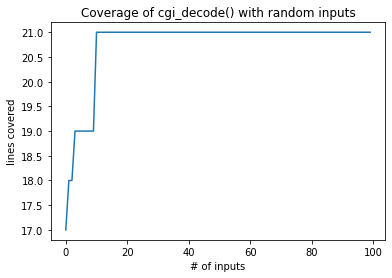

In [41]:
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

This is just _one_ run, of course; so let's repeat this a number of times and plot the averages.

In [42]:
runs = 100

# Create an array with TRIALS elements, all zero
sum_coverage = [0] * trials

for run in range(runs):
    all_coverage, coverage = population_coverage(hundred_inputs(), cgi_decode)
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]

average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

Text(0, 0.5, 'lines covered')

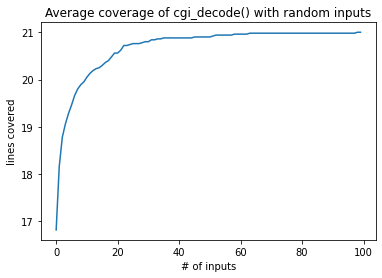

In [43]:
plt.plot(average_coverage)
plt.title('Average coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')

We see that on average, we get full coverage after 40–60 fuzzing inputs.

## Getting Coverage from External Programs

Of course, not all the world is programming in Python.  The good news is that the problem of obtaining coverage is ubiquitous, and almost every programming language has some facility to measure coverage.  Just as an example, let us therefore demonstrate how to obtain coverage for a C program.

Our C program (again) implements `cgi_decode`; this time as a program to be executed from the command line:

```shell
$ ./cgi_decode 'Hello+World'
Hello World
```

Here comes the C code, first as a Python string.  We start with the usual C includes:

In [44]:
cgi_c_code = """
/* CGI decoding as C program */

#include <stdlib.h>
#include <string.h>
#include <stdio.h>

"""

Here comes the initialization of `hex_values`:

In [45]:
cgi_c_code += r"""
int hex_values[256];

void init_hex_values() {
    for (int i = 0; i < sizeof(hex_values) / sizeof(int); i++) {
        hex_values[i] = -1;
    }
    hex_values['0'] = 0; hex_values['1'] = 1; hex_values['2'] = 2; hex_values['3'] = 3;
    hex_values['4'] = 4; hex_values['5'] = 5; hex_values['6'] = 6; hex_values['7'] = 7;
    hex_values['8'] = 8; hex_values['9'] = 9;

    hex_values['a'] = 10; hex_values['b'] = 11; hex_values['c'] = 12; hex_values['d'] = 13;
    hex_values['e'] = 14; hex_values['f'] = 15;

    hex_values['A'] = 10; hex_values['B'] = 11; hex_values['C'] = 12; hex_values['D'] = 13;
    hex_values['E'] = 14; hex_values['F'] = 15;
}
"""

Here's the actual implementation of `cgi_decode()`, using pointers for input source (`s`) and output target (`t`):

In [46]:
cgi_c_code += r"""
int cgi_decode(char *s, char *t) {
    while (*s != '\0') {
        if (*s == '+')
            *t++ = ' ';
        else if (*s == '%') {
            int digit_high = *++s;
            int digit_low = *++s;
            if (hex_values[digit_high] >= 0 && hex_values[digit_low] >= 0) {
                *t++ = hex_values[digit_high] * 16 + hex_values[digit_low];
            }
            else
                return -1;
        }
        else
            *t++ = *s;
        s++;
    }
    *t = '\0';
    return 0;
}
"""

Finally, here's a driver which takes the first argument and invokes `cgi_decode` with it:

In [47]:
cgi_c_code += r"""
int main(int argc, char *argv[]) {
    init_hex_values();

    if (argc >= 2) {
        char *s = argv[1];
        char *t = malloc(strlen(s) + 1); /* output is at most as long as input */
        int ret = cgi_decode(s, t);
        printf("%s\n", t);
        return ret;
    }
    else
    {
        printf("cgi_decode: usage: cgi_decode STRING\n");
        return 1;
    }
}
"""

Let us create the C source code: (Note that the following commands will overwrite the file `cgi_decode.c`, if it already exists in the current working directory. Be aware of this, if you downloaded the notebooks and are working locally.)

In [48]:
with open("cgi_decode.c", "w") as f:
    f.write(cgi_c_code)

And here we have the C code with its syntax highlighted:

In [49]:
from bookutils import print_file

In [50]:
print_file("cgi_decode.c")

/* CGI decoding as C program */

#include <stdlib.h>
#include <string.h>
#include <stdio.h>


int hex_values[256];

void init_hex_values() {
    for (int i = 0; i < sizeof(hex_values) / sizeof(int); i++) {
        hex_values[i] = -1;
    }
    hex_values['0'] = 0; hex_values['1'] = 1; hex_values['2'] = 2; hex_values['3'] = 3;
    hex_values['4'] = 4; hex_values['5'] = 5; hex_values['6'] = 6; hex_values['7'] = 7;
    hex_values['8'] = 8; hex_values['9'] = 9;

    hex_values['a'] = 10; hex_values['b'] = 11; hex_values['c'] = 12; hex_values['d'] = 13;
    hex_values['e'] = 14; hex_values['f'] = 15;

    hex_values['A'] = 10; hex_values['B'] = 11; hex_values['C'] = 12; hex_values['D'] = 13;
    hex_values['E'] = 14; hex_values['F'] = 15;
}

int cgi_decode(char *s, char *t) {
    while (*s != '\0') {
        if (*s == '+')
            *t++ = ' ';
        else if (*s == '%') {
            int digit_high = *++s;
            int digit_low = *++s;
            if (hex_values[digit_high] >= 0 && 

We can now compile the C code into an executable.  The `--coverage` option instructs the C compiler to instrument the code such that at runtime, coverage information will be collected.  (The exact options vary from compiler to compiler.)

In [51]:
!cc --coverage -o cgi_decode cgi_decode.c

When we now execute the program, coverage information will automatically be collected and stored in auxiliary files:

In [52]:
!./cgi_decode 'Send+mail+to+me%40fuzzingbook.org'

Send mail to me@fuzzingbook.org


The coverage information is collected by the `gcov` program.  For every source file given, it produces a new `.gcov` file with coverage information.

In [53]:
!gcov cgi_decode.c

File 'cgi_decode.c'
Lines executed:92.50% of 40
Creating 'cgi_decode.c.gcov'



In the `.gcov` file, each line is prefixed with the number of times it was called (`-` stands for a non-executable line, `#####` stands for zero) as well as the line number.  We can take a look at `cgi_decode()`, for instance, and see that the only code not executed yet is the `return -1` for an illegal input.

In [54]:
lines = open('cgi_decode.c.gcov').readlines()
for i in range(30, 50):
    print(lines[i], end='')

        1:   26:int cgi_decode(char *s, char *t) {
       32:   27:    while (*s != '\0') {
       31:   28:        if (*s == '+')
        3:   29:            *t++ = ' ';
       28:   30:        else if (*s == '%') {
        1:   31:            int digit_high = *++s;
        1:   32:            int digit_low = *++s;
        1:   33:            if (hex_values[digit_high] >= 0 && hex_values[digit_low] >= 0) {
        1:   34:                *t++ = hex_values[digit_high] * 16 + hex_values[digit_low];
        1:   35:            }
        -:   36:            else
    #####:   37:                return -1;
        1:   38:        }
        -:   39:        else
       27:   40:            *t++ = *s;
       31:   41:        s++;
        -:   42:    }
        1:   43:    *t = '\0';
        1:   44:    return 0;
        1:   45:}


Let us read in this file to obtain a coverage set:

In [55]:
def read_gcov_coverage(c_file):
    gcov_file = c_file + ".gcov"
    coverage = set()
    with open(gcov_file) as file:
        for line in file.readlines():
            elems = line.split(':')
            covered = elems[0].strip()
            line_number = int(elems[1].strip())
            if covered.startswith('-') or covered.startswith('#'):
                continue
            coverage.add((c_file, line_number))
    return coverage

In [56]:
coverage = read_gcov_coverage('cgi_decode.c')

In [57]:
list(coverage)[:5]

[('cgi_decode.c', 11),
 ('cgi_decode.c', 17),
 ('cgi_decode.c', 14),
 ('cgi_decode.c', 20),
 ('cgi_decode.c', 26)]

With this set, we can now do the same coverage computations as with our Python programs.

## Finding Errors with Basic Fuzzing

Given sufficient time, we can indeed cover each and every line within `cgi_decode()`, whatever the programming language would be.  This does not mean that they would be error-free, though.  Since we do not check the result of `cgi_decode()`, the function could return any value without us checking or noticing.  To catch such errors, we would have to set up a *results checker* (commonly called an *oracle*) that would verify test results.  In our case, we could compare the C and Python implementations of `cgi_decode()` and see whether both produce the same results.

Where fuzzing is great at, though, is in finding _internal errors_ that can be detected even without checking the result.  Actually, if one runs our `fuzzer()` on `cgi_decode()`, one quickly finds such an error, as the following code shows:

In [58]:
from ExpectError import ExpectError

In [59]:
with ExpectError():
    for i in range(trials):
        try:
            s = fuzzer()
            cgi_decode(s)
        except ValueError:
            pass

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/2238772797.py", line 5, in <cell line: 1>
    cgi_decode(s)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/1071239422.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
IndexError: string index out of range (expected)


So, it is possible to cause `cgi_decode()` to crash.  Why is that?  Let's take a look at its input:

In [60]:
s

'82 202*&<1&($34\'"/\'.<5/!8"\'5:!4))%;'

The problem here is at the end of the string.  After a `'%'` character, our implementation will always attempt to access two more (hexadecimal) characters, but if these are not there, we will get an `IndexError` exception.  

This problem is also present in our C variant, which inherits it from the original implementation \cite{Pezze2008}:

```c
int digit_high = *++s;
int digit_low = *++s;
```

Here, `s` is a pointer to the character to be read; `++` increments it by one character.
In the C implementation, the problem is actually much worse.  If the `'%'` character is at the end of the string, the above code will first read a terminating character (`'\0'` in C strings) and then the following character, which may be any memory content after the string, and which thus may cause the program to fail uncontrollably.  The somewhat good news is that `'\0'` is not a valid hexadecimal character, and thus, the C version will "only" read one character beyond the end of the string.

Interestingly enough, none of the manual tests we had designed earlier would trigger this bug.  Actually, neither statement nor branch coverage, nor any of the coverage criteria commonly discussed in literature would find it.  However, a simple fuzzing run can identify the error with a few runs – _if_ appropriate run-time checks are in place that find such overflows.  This definitely calls for more fuzzing!

## Synopsis

This chapter introduces a `Coverage` class allowing you to measure coverage for Python programs. Within the context of this book, we use coverage information to guide fuzzing towards uncovered locations.

The typical usage of the `Coverage` class is in conjunction with a `with` clause:

In [61]:
with Coverage() as cov:
    cgi_decode("a+b")

Printing out a coverage object shows the covered functions, with covered lines prefixed as `#`:

In [62]:
print(cov)

   1  def cgi_decode(s: str) -> str:
   2      """Decode the CGI-encoded string `s`:
   3         * replace '+' by ' '
   4         * replace "%xx" by the character with hex number xx.
   5         Return the decoded string.  Raise `ValueError` for invalid inputs."""
   6  
   7      # Mapping of hex digits to their integer values
#  8      hex_values = {
#  9          '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
# 10          '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
# 11          'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
# 12          'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
  13      }
  14  
# 15      t = ""
# 16      i = 0
# 17      while i < len(s):
# 18          c = s[i]
# 19          if c == '+':
# 20              t += ' '
# 21          elif c == '%':
  22              digit_high, digit_low = s[i + 1], s[i + 2]
  23              i += 2
  24              if digit_high in hex_values and digit_low in hex_values:
  25                  v = hex_values[digit_high] * 

The `trace()` method returns the _trace_ – that is, the list of locations executed in order. Each location comes as a pair (`function name`, `line`).

In [63]:
cov.trace()

[('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 10),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 11),
 ('cgi_decode', 8),
 ('cgi_decode', 12),
 ('cgi_decode', 8),
 ('cgi_decode', 12),
 ('cgi_decode', 8),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 

The `coverage()` method returns the _coverage_, that is, the set of locations in the trace executed at least once:

In [64]:
cov.coverage()

{('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 10),
 ('cgi_decode', 11),
 ('cgi_decode', 12),
 ('cgi_decode', 15),
 ('cgi_decode', 16),
 ('cgi_decode', 17),
 ('cgi_decode', 18),
 ('cgi_decode', 19),
 ('cgi_decode', 20),
 ('cgi_decode', 21),
 ('cgi_decode', 30),
 ('cgi_decode', 31),
 ('cgi_decode', 32)}

Coverage sets can be subject to set operations, such as _intersection_ (which locations are covered in multiple executions) and _difference_ (which locations are covered in run _a_, but not _b_).

The chapter also discusses how to obtain such coverage from C programs.

In [65]:
# ignore
from ClassDiagram import display_class_hierarchy

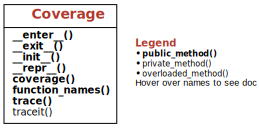

In [66]:
# ignore
display_class_hierarchy(Coverage,
                        public_methods=[
                            Coverage.__init__,
                            Coverage.__enter__,
                            Coverage.__exit__,
                            Coverage.coverage,
                            Coverage.trace,
                            Coverage.function_names,
                            Coverage.__repr__,
                        ],
                        types={'Location': Location},
                        project='fuzzingbook')

## Lessons Learned

* Coverage metrics are a simple and fully automated means to approximate how much functionality of a program is actually executed during a test run.
* A number of coverage metrics exist, the most important ones being statement coverage and branch coverage.
* In Python, it is very easy to access the program state during execution, including the currently executed code.

At the end of the day, let's clean up: (Note that the following commands will delete all files in the current working directory that fit the pattern `cgi_decode.*`. Be aware of this, if you downloaded the notebooks and are working locally.)

In [67]:
import os
import glob

In [68]:
for file in glob.glob("cgi_decode") + glob.glob("cgi_decode.*"):
    os.remove(file)

## Next Steps

Coverage is not only a tool to _measure_ test effectiveness, but also a great tool to _guide_ test generation towards specific goals – in particular uncovered code.  We use coverage to

* [guide _mutations_ of existing inputs towards better coverage in the chapter on mutation fuzzing](MutationFuzzer.ipynb)


## Background

Coverage is a central concept in systematic software testing.  For discussions, see the books in the [Introduction to Testing](Intro_Testing.ipynb).

## Exercises

### Exercise 1: Fixing `cgi_decode()`

Create an appropriate test to reproduce the `IndexError` discussed above.  Fix `cgi_decode()` to prevent the bug.  Show that your test (and additional `fuzzer()` runs) no longer expose the bug.  Do the same for the C variant.

**Solution.**  Here's a test case:

In [69]:
with ExpectError():
    assert cgi_decode('%') == '%'

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/1102034435.py", line 2, in <cell line: 1>
    assert cgi_decode('%') == '%'
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/1071239422.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
IndexError: string index out of range (expected)


In [70]:
with ExpectError():
    assert cgi_decode('%4') == '%4'

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/2291699482.py", line 2, in <cell line: 1>
    assert cgi_decode('%4') == '%4'
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_73355/1071239422.py", line 22, in cgi_decode
    digit_high, digit_low = s[i + 1], s[i + 2]
IndexError: string index out of range (expected)


In [71]:
assert cgi_decode('%40') == '@'

Here's a fix:

In [72]:
def fixed_cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%' and i + 2 < len(s):  # <--- *** FIX ***
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t

In [73]:
assert fixed_cgi_decode('%') == '%'

In [74]:
assert fixed_cgi_decode('%4') == '%4'

In [75]:
assert fixed_cgi_decode('%40') == '@'

Here's the test:

In [76]:
for i in range(trials):
    try:
        s = fuzzer()
        fixed_cgi_decode(s)
    except ValueError:
        pass

For the C variant, the following will do:

In [77]:
cgi_c_code = cgi_c_code.replace(
    r"if (*s == '%')",  # old code
    r"if (*s == '%' && s[1] != '\0' && s[2] != '\0')"  # new code
)

Go back to the above compilation commands and recompile `cgi_decode`.

### Exercise 2: Branch Coverage

Besides statement coverage, _branch coverage_ is one of the most frequently used criteria to determine the quality of a test.  In a nutshell, branch coverage measures how many _control decisions_ are made in code.  In the statement

```python
if CONDITION:
    do_a()
else:
    do_b()
```

for instance, both the cases where `CONDITION` is true (branching to `do_a()`) and where `CONDITION` is false (branching to `do_b()`) have to be covered.  This holds for all control statements with a condition (`if`, `while`, etc.).

How is branch coverage different from statement coverage?  In the above example, there is actually no difference.  In this one, though, there is:

```python
if CONDITION:
    do_a()
something_else()
```

Using statement coverage, a single test case where `CONDITION` is true suffices to cover the call to `do_a()`.  Using branch coverage, however, we would also have to create a test case where `do_a()` is _not_ invoked.

Using our `Coverage` infrastructure, we can simulate branch coverage by considering _pairs of subsequent lines executed_.  The `trace()` method gives us the list of lines executed one after the other:

In [78]:
with Coverage() as cov:
    cgi_decode("a+b")
trace = cov.trace()
trace[:5]

[('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8),
 ('cgi_decode', 9),
 ('cgi_decode', 8)]

#### Part 1: Compute branch coverage

Define a function `branch_coverage()` that takes a trace and returns the set of pairs of subsequent lines in a trace – in the above example, this would be 

```python
set(
(('cgi_decode', 9), ('cgi_decode', 10)),
(('cgi_decode', 10), ('cgi_decode', 11)),
# more_pairs
)
```

Bonus for advanced Python programmers: Define `BranchCoverage` as a subclass of `Coverage` and make `branch_coverage()` as above a `coverage()` method of `BranchCoverage`.

**Solution.**  Here's a simple definition of `branch_coverage()`:

In [79]:
def branch_coverage(trace):
    coverage = set()
    past_line = None
    for line in trace:
        if past_line is not None:
            coverage.add((past_line, line))
        past_line = line

    return coverage

In [80]:
branch_coverage(trace)

{(('cgi_decode', 8), ('cgi_decode', 9)),
 (('cgi_decode', 8), ('cgi_decode', 10)),
 (('cgi_decode', 8), ('cgi_decode', 11)),
 (('cgi_decode', 8), ('cgi_decode', 12)),
 (('cgi_decode', 8), ('cgi_decode', 15)),
 (('cgi_decode', 9), ('cgi_decode', 8)),
 (('cgi_decode', 10), ('cgi_decode', 8)),
 (('cgi_decode', 11), ('cgi_decode', 8)),
 (('cgi_decode', 12), ('cgi_decode', 8)),
 (('cgi_decode', 15), ('cgi_decode', 16)),
 (('cgi_decode', 16), ('cgi_decode', 17)),
 (('cgi_decode', 17), ('cgi_decode', 18)),
 (('cgi_decode', 17), ('cgi_decode', 32)),
 (('cgi_decode', 18), ('cgi_decode', 19)),
 (('cgi_decode', 19), ('cgi_decode', 20)),
 (('cgi_decode', 19), ('cgi_decode', 21)),
 (('cgi_decode', 20), ('cgi_decode', 31)),
 (('cgi_decode', 21), ('cgi_decode', 30)),
 (('cgi_decode', 30), ('cgi_decode', 31)),
 (('cgi_decode', 31), ('cgi_decode', 17))}

Here's a definition as a class:

In [81]:
class BranchCoverage(Coverage):
    def coverage(self):
        """The set of executed line pairs"""
        coverage = set()
        past_line = None
        for line in self.trace():
            if past_line is not None:
                coverage.add((past_line, line))
            past_line = line

        return coverage

#### Part 2: Comparing statement coverage and branch coverage

Use `branch_coverage()` to repeat the experiments in this chapter with branch coverage rather than statement coverage.  Do the manually written test cases cover all branches?

**Solution.** Let's repeat the above experiments with `BranchCoverage`:

In [82]:
with BranchCoverage() as cov:
    cgi_decode("a+b")

print(cov.coverage())

{(('cgi_decode', 11), ('cgi_decode', 8)), (('cgi_decode', 8), ('cgi_decode', 9)), (('cgi_decode', 31), ('cgi_decode', 17)), (('cgi_decode', 8), ('cgi_decode', 15)), (('cgi_decode', 15), ('cgi_decode', 16)), (('cgi_decode', 20), ('cgi_decode', 31)), (('cgi_decode', 8), ('cgi_decode', 10)), (('cgi_decode', 16), ('cgi_decode', 17)), (('cgi_decode', 18), ('cgi_decode', 19)), (('cgi_decode', 17), ('cgi_decode', 32)), (('cgi_decode', 8), ('cgi_decode', 11)), (('cgi_decode', 19), ('cgi_decode', 20)), (('cgi_decode', 9), ('cgi_decode', 8)), (('cgi_decode', 30), ('cgi_decode', 31)), (('cgi_decode', 17), ('cgi_decode', 18)), (('cgi_decode', 21), ('cgi_decode', 30)), (('cgi_decode', 10), ('cgi_decode', 8)), (('cgi_decode', 19), ('cgi_decode', 21)), (('cgi_decode', 8), ('cgi_decode', 12)), (('cgi_decode', 12), ('cgi_decode', 8))}


In [83]:
with BranchCoverage() as cov_plus:
    cgi_decode("a+b")
with BranchCoverage() as cov_standard:
    cgi_decode("abc")

cov_plus.coverage() - cov_standard.coverage()

{(('cgi_decode', 19), ('cgi_decode', 20)),
 (('cgi_decode', 20), ('cgi_decode', 31))}

In [84]:
with BranchCoverage() as cov_max:
    cgi_decode('+')
    cgi_decode('%20')
    cgi_decode('abc')
    try:
        cgi_decode('%?a')
    except:
        pass

In [85]:
cov_max.coverage() - cov_plus.coverage()

{(('cgi_decode', 21), ('cgi_decode', 22)),
 (('cgi_decode', 22), ('cgi_decode', 23)),
 (('cgi_decode', 23), ('cgi_decode', 24)),
 (('cgi_decode', 24), ('cgi_decode', 25)),
 (('cgi_decode', 24), ('cgi_decode', 28)),
 (('cgi_decode', 25), ('cgi_decode', 26)),
 (('cgi_decode', 26), ('cgi_decode', 31)),
 (('cgi_decode', 32), ('cgi_decode', 8))}

In [86]:
sample

'!7#%"*#0=)$;%6*;>638:*>80"=</>(/*:-(2<4 !:5*6856&?""11<7+%<%7,4.8,*+&,,$,."'

In [87]:
with BranchCoverage() as cov_fuzz:
    try:
        cgi_decode(s)
    except:
        pass
cov_fuzz.coverage()

{(('cgi_decode', 8), ('cgi_decode', 9)),
 (('cgi_decode', 8), ('cgi_decode', 10)),
 (('cgi_decode', 8), ('cgi_decode', 11)),
 (('cgi_decode', 8), ('cgi_decode', 12)),
 (('cgi_decode', 8), ('cgi_decode', 15)),
 (('cgi_decode', 9), ('cgi_decode', 8)),
 (('cgi_decode', 10), ('cgi_decode', 8)),
 (('cgi_decode', 11), ('cgi_decode', 8)),
 (('cgi_decode', 12), ('cgi_decode', 8)),
 (('cgi_decode', 15), ('cgi_decode', 16)),
 (('cgi_decode', 16), ('cgi_decode', 17)),
 (('cgi_decode', 17), ('cgi_decode', 18)),
 (('cgi_decode', 18), ('cgi_decode', 19)),
 (('cgi_decode', 19), ('cgi_decode', 20)),
 (('cgi_decode', 19), ('cgi_decode', 21)),
 (('cgi_decode', 20), ('cgi_decode', 31)),
 (('cgi_decode', 21), ('cgi_decode', 22)),
 (('cgi_decode', 21), ('cgi_decode', 30)),
 (('cgi_decode', 22), ('cgi_decode', 23)),
 (('cgi_decode', 23), ('cgi_decode', 24)),
 (('cgi_decode', 24), ('cgi_decode', 28)),
 (('cgi_decode', 30), ('cgi_decode', 31)),
 (('cgi_decode', 31), ('cgi_decode', 17))}

In [88]:
cov_max.coverage() - cov_fuzz.coverage()

{(('cgi_decode', 17), ('cgi_decode', 32)),
 (('cgi_decode', 24), ('cgi_decode', 25)),
 (('cgi_decode', 25), ('cgi_decode', 26)),
 (('cgi_decode', 26), ('cgi_decode', 31)),
 (('cgi_decode', 32), ('cgi_decode', 8))}

In [89]:
def population_branch_coverage(population, function):
    cumulative_coverage = []
    all_coverage = set()

    for s in population:
        with BranchCoverage() as cov:
            try:
                function(s)
            except Exception:
                pass
        all_coverage |= cov.coverage()
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage

In [90]:
all_branch_coverage, cumulative_branch_coverage = population_branch_coverage(
    hundred_inputs(), cgi_decode)

Text(0, 0.5, 'line pairs covered')

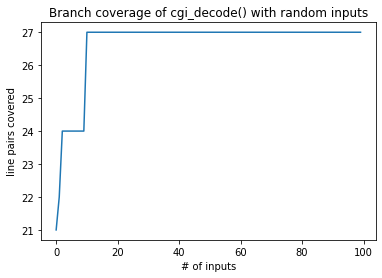

In [91]:
plt.plot(cumulative_branch_coverage)
plt.title('Branch coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('line pairs covered')

In [92]:
len(cov_max.coverage())

28

In [93]:
all_branch_coverage - cov_max.coverage()

set()

The additional coverage comes from the exception raised via an illegal input (say, `%g`).

In [94]:
cov_max.coverage() - all_branch_coverage

{(('cgi_decode', 32), ('cgi_decode', 8))}

This is an artifact coming from the subsequent execution of `cgi_decode()` when computing `cov_max`.

#### Part 3: Average coverage

Again, repeat the above experiments with branch coverage.  Does `fuzzer()` cover all branches, and if so, how many tests does it take on average?

**Solution.** We repeat the experiments we ran with line coverage with branch coverage.

In [95]:
runs = 100

# Create an array with TRIALS elements, all zero
sum_coverage = [0] * trials

for run in range(runs):
    all_branch_coverage, coverage = population_branch_coverage(
        hundred_inputs(), cgi_decode)
    assert len(coverage) == trials
    for i in range(trials):
        sum_coverage[i] += coverage[i]

average_coverage = []
for i in range(trials):
    average_coverage.append(sum_coverage[i] / runs)

Text(0, 0.5, 'line pairs covered')

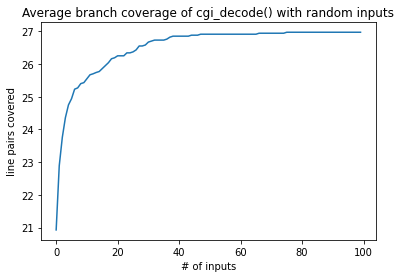

In [96]:
plt.plot(average_coverage)
plt.title('Average branch coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('line pairs covered')

We see that achieving branch coverage takes longer than statement coverage; it simply is a more difficult criterion to satisfy with random inputs.